# Creating Indicators

Now that we know how to load data and deal with dataframes using pandas, we should try to see if we can identify some technical indicators that will help us to trade



In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from dateutil.parser import *
from datetime import *
from dateutil.rrule import *
%matplotlib inline

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [10]:
#%run Pandas-StockPrices.ipynb
%run ./utils.py
%run ./functions.py

In [5]:
pd.set_option('display.max_rows',10)

In [11]:
df_aapl = GetHistoricalTicker('aapl',full=True, save_data=True)
df_aapl.sort_index(ascending=False, inplace=True)
df_aapl.head()
df_aapl.tail()

,open,high,low,close,adjusted close,volume,dividend amt,split coef
date,,,,,,,,
2019-11-01,249.54,255.93,249.16,255.82,254.451,37781334.0,0.0,1.0
2019-10-31,247.24,249.17,237.26,248.76,247.429,34790520.0,0.0,1.0
2019-10-30,244.76,245.30,241.21,243.26,241.958,31130522.0,0.0,1.0
2019-10-29,248.97,249.75,242.57,243.29,241.988,35709867.0,0.0,1.0
2019-10-28,247.42,249.25,246.72,249.05,247.717,23655368.0,0.0,1.0


In [12]:
df_bc = GetCrypto('BTC')
df_bc

0


,open,high,low,close,volume,market cap
date,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150,795.150
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888,1199.888
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.310,381.310
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083,467.083
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743,691.743
...,...,...,...,...,...,...
2020-03-17,5028.86,5525.00,4921.45,5312.64,150089.926,150089.926
2020-03-18,5312.64,5436.17,5009.37,5393.04,137127.635,137127.635
2020-03-19,5393.26,6400.00,5252.53,6162.37,199020.873,199020.873


# Calculating Special Metrics

Let's start by building a few special metrics like moving averages

The weighted average is calculated by multiplying the given price by its associated weighting and totaling the values. The formula for the WMA is as follows:

\begin{aligned} &\text{WMA} = \frac{ \text{Price}_1 \times n + \text{Price}_2 \times ( n - 1 ) + \cdots \text{ Price}_n }{ \frac{ n \times ( n + 1 ) }{ 2} } \\ &\textbf{where:} \\ &n = \text{Time period} \\ \end{aligned} 
​	  
WMA= 
2
n×(n+1)
​	 
Price 
1
​	 ×n+Price 
2
​	 ×(n−1)+⋯ Price 
n
​	 
​	 
where:
n=Time period
​	
Exponential Moving Averages
Exponential moving averages (EMAs) are also weighted toward the most recent prices, but the rate of decrease between one price and its preceding price is not consistent. The difference in the decrease is exponential. Rather than every preceding weight being 1.0 smaller than the weight in front of it, there might be a difference between the first two period weights of 1.0, a difference of 1.2 for the two periods after those periods, and so on. The formula for EMA is

\begin{aligned} &\text{EMA} = \text{Price}_t \times k + \text{SMA}_y \times ( 1 - k ) \\ &\textbf{where:} \\ &t = \text{Today} \\ &k = \frac { 2 }{ \text{Number of days in period} + 1 } \\ &\text{SMA} = \text{Simple Moving Average of closing price} \\ &\text{for the number of days in the period} \\ &y = \text{Yesterday} \\ \end{aligned} 
​	  
EMA=Price 
t
​	 ×k+SMA 
y
​	 ×(1−k)
where:
t=Today
k= 
Number of days in period+1
2
​	 
SMA=Simple Moving Average of closing price
for the number of days in the period
y=Yesterday
​	

In [14]:
# First we are going to add a function that will help us deal with naming all the columns we are going to have
from enum import Enum
class CNames(Enum):
    SIMPLE_MOVING_AVG = 'SMA'
    WEIGHTED_MOVING_AVG = 'WMA'
    EXP_MOVING_AVG='EMA'
    SIGMA = 'Volatility'
    TOTAL_PRICE_RETURN = 'total price return'
    TOTAL_PRICE_RETURN_FWD = 'total price return (fwd)'
    PCT_DAY_CHANGE = 'pct daily change'
    MCAD = 'Moving Avg Conv-Diver'

    def make_column_name(self, period, period_type='d'):
        """
        The purpose of this function is to ensure that create columns (from the Calculate*
        functions) are consistent and don't have to be known to the caller

        Example:
        `30_DMA = CNames.SIMPLE_MOVING_AVG.make_column_name(30)
        `30_DMA 
        :param period: the number of days in the column to get
        :param period_type: one of (day, week, month or year) 'd', 'w', 'm' or 'y'
        :return:
        """
        return f'{period}{period_type} {self.value}'
    
    def mult_periods(self, periods, period_type='d'):
        """
        The purpose of this function is to get a list of column names from a range of periods

        Example:
        `SMA_Periods = CNames.SIMPLE_MOVING_AVG.mult_periods([5,10,30])
        `SMA_Periods 
        :param period: a list of the number of days in the column to get
        :param period_type: one of (day, week, month or year) 'd', 'w', 'm' or 'y'
        :return: a list of column names
        """
        return [self.make_column_name(x,period_type) for x in periods]
        

In [17]:
def calc_simple_moving_average(price_series, term=30):
    '''
    Here we'll calculate Simple Moving Average for a particular series
    This will allow the user to pick a particular column, whether it be Adjusted Close, Close, Open, etc.
    '''
    return price_series.rolling(term).mean()

def calc_wgt_moving_average(price_series, term=30):
    '''
    Calculating the weighted moving average says to give more weight to more recent dates
    '''
    weights = np.arange(term,0,-1) / ((term * (term+1))/2)
    return price_series.rolling(term).apply(lambda x: np.average(x, weights=weights), raw=True)

def calc_exp_moving_average(price_series, term=30):
    return price_series.ewm(span=term).mean()

df_aapl.sort_index(inplace=True)
periods = [5,10,15,30,50,90,200,300]
close_key = ADJ_CLOSE

for x in periods:
    df_aapl[CNames.SIMPLE_MOVING_AVG.make_column_name(x)]=calc_simple_moving_average(df_aapl[close_key],x)
    df_aapl[CNames.EXP_MOVING_AVG.make_column_name(x)]=calc_exp_moving_average(df_aapl[close_key],x)
    df_aapl[CNames.WEIGHTED_MOVING_AVG.make_column_name(x)]=calc_wgt_moving_average(df_aapl[close_key],x)
    



date
2019-10-28   NaN
2019-10-29   NaN
2019-10-30   NaN
2019-10-31   NaN
2019-11-01   NaN
              ..
2020-03-16   NaN
2020-03-17   NaN
2020-03-18   NaN
2020-03-19   NaN
2020-03-20   NaN
Name: 200d SMA, Length: 100, dtype: float64

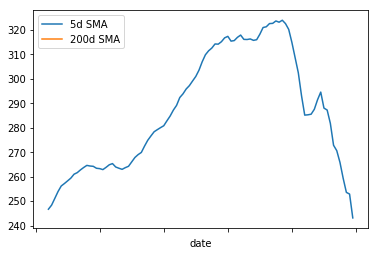

In [19]:
SMA = CNames.SIMPLE_MOVING_AVG.mult_periods([5,200])
df_aapl[SMA].plot();
df_aapl[SMA[1]]

# What Is Moving Average Convergence Divergence – MACD?
Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

The result of that calculation is the MACD line. A nine-day EMA of the MACD called the "signal line," is then plotted on top of the MACD line, which can function as a trigger for buy and sell signals. Traders may buy the security when the MACD crosses above its signal line and sell - or short - the security when the MACD crosses below the signal line. Moving Average Convergence Divergence (MACD) indicators can be interpreted in several ways, but the more common methods are crossovers, divergences, and rapid rises/falls.

<p style='text-align: center;'>The Formula for MACD:</p>
<p style='text-align: center;'>${MACD}={12-Period EMA }-{ 26-Period EMA}$</p>

In [20]:
def calc_macd(price_series):
    return calc_exp_moving_average(price_series, 12) - calc_exp_moving_average(price_series,26)

df_aapl[CNames.MCAD] = calc_macd(df_aapl[ADJ_CLOSE])

In [31]:
mcad_50 = df_aapl[CNames.MCAD].iloc[:50]
mcad_9 = df_aapl[CNames.MCAD].iloc[:50]


fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot([mcad_9, mcad_50], color=['blue','red'])
plt.show();


ValueError: Invalid RGBA argument: ['blue', 'red']

<Figure size 432x288 with 1 Axes>